# Calculating excited states with the Variational Quantum Eigensolver (VQE)

VQE optimizes a wave function to minimize the expectation value of Hamiltonian. Therefore, VQE can only calculate the ground state. In this time, we will explain how to calculate the excited state using VQE, and we will show the example of the calculation for the excited state of the hydrogen molecule. 

## Theoretical Outline
This time we will use an [Overlap-based method](https://quantum-journal.org/papers/q-2019-07-01-156/) to calculate the $1^{st}$ excited state. This method uses a penalty term for the overlap between the wavefunctions of the VQE and the ground state. The excited state can be obtained by adding the penalty term to Hamiltonian. An equation is as follows
$$
\begin{equation}
H^\prime=H+\alpha \vert \psi_{gs}\rangle\langle\psi_{gs} \vert
\end{equation}
$$
The $H$ on the right-hand side is the original Hamiltonian. The second term on the right side evaluates the value of the overlap with the ground-state wave function $ \vert \psi_{gs}\rangle$ (In this tutorial, $ \vert \psi_{gs}\rangle$ is obtained by a classical calculation, but it is also possible to use VQE). $\alpha$ in the second term is a parameter that represents a penalty, and we take a large enough value about it. By adding the penalty term to the original $H$ term, we define $H^\prime$.

We evaluate the expected value by using the wave function $ \vert \psi_{VQE}\rangle$ obtained from the VQE.
$$
\begin{equation}
\langle\psi_{VQE} \vert H^\prime \vert \psi_{VQE}\rangle=\langle\psi_{VQE} \vert H \vert \psi_{VQE}\rangle+\alpha\langle\psi_{VQE} \vert \psi_{gs}\rangle\langle\psi_{gs} \vert \psi_{VQE}\rangle\\
=\langle\psi_{VQE} \vert H \vert \psi_{VQE}\rangle+\alpha \vert \langle\psi_{gs} \vert \psi_{VQE}\rangle \vert ^2
\end{equation}
$$
Since the excited state is orthogonal to the ground state, the second term in the above equation is zero if $ \vert \psi_{VQE}\rangle$ becomes the excited state. In this time, we will use this expectation value to implement the excited-state calculation of hydrogen molecule in VQE.

Incidentally, If the wanted wavefunction is not the $1^{st}$ excited state but the $N^{th}$ excited state, penalty terms are created by using the wavefunction from the ground state to the ${N-1}^{th}$ excited state.
$$
\begin{equation}
H^\prime=H+\sum_{i=gs}^{N-1}\alpha_i \vert \psi_{i}\rangle\langle\psi_{i} \vert 
\end{equation}
$$

## Preparation
Install the necessary libraries. The Hamiltonian is obtained with OpenFermion.

Import the necessary libraries. The optimization of VQE uses SciPy minimize.

In [1]:
!pip3 install blueqat openfermion

Defaulting to user installation because normal site-packages is not writeable


In [2]:
from blueqat import Circuit
from openfermion.hamiltonians import MolecularData
from openfermion.transforms import get_fermion_operator, jordan_wigner, get_sparse_operator
import numpy as np
from scipy.optimize import minimize

KeyboardInterrupt: 

## Ansatz definition and molecular information acquisition
Define the functions for calculating VQE and obtaining information about the molecule. The calculations are performed using Hardware Efficient Ansatz. The initial wavefunction is set to a triplet state $|1010\rangle$.
The molecular information is obtained using OpenFermion. The basis set is STO-3G.

In [4]:
def HEA(params,n_qubits,n_depth):
    #Wave function initialization |1010>
    circ=Circuit().x[1, 3]

    #Circuit creation
    params_devided=np.array_split(params,n_depth)
    for params_one_depth in params_devided:
        for i,param in enumerate(params_one_depth):
            if i < n_qubits:
                circ.ry(param)[i]
            else:
                circ.rz(param)[i%n_qubits]
        for qbit in range(n_qubits):
            if qbit < n_qubits-1:
                circ.cz[qbit,qbit+1]
    
    #Running the circuit
    wf = circ.run(backend="numpy")
    return wf

def get_molecule(length):
    geometry = [('H',(0.,0.,0.)),('H',(0.,0.,length))]
    try:
        description = f'{length:.2f}'
        molecule = MolecularData(geometry, "sto-3g",1,description=description)
        molecule.load()
    except:
        description = f'{length:.1f}'
        molecule = MolecularData(geometry, "sto-3g",1,description=description)
        molecule.load()
    return molecule

## Expected value and cost function
The expected value is calculated using the wave function obtained by VQE. In the expected value calculation, the term concerning the overlap between the ground state and the VQE wave functions is added to the original expected value of the Hamiltonian.

In [5]:
def expect_exited_state(wf,hamiltonian,penalty,wf_gs):
    #Calculating Hamiltonian+penalty 
    hamiltonian_overlap= np.vdot(wf, hamiltonian.dot(wf)).real+penalty*np.abs(np.vdot(wf_gs,wf))**2
    return hamiltonian_overlap

def cost(params,hamiltonian,n_qubits,n_depth,penalty,wf_gs):
    wf=HEA(params,n_qubits,n_depth)
    return expect_exited_state(wf,hamiltonian,penalty,wf_gs)

## Calculation execution and plotting
Run VQE on each bond length (this will take a few minutes). This time, the wave function of the ground state is classically obtained, but it can be calculated by VQE. The penalty value is 10 Hartree.
After the calculation, compare the calculated results of VQE, ground state, and first excited state for energy and bond length.

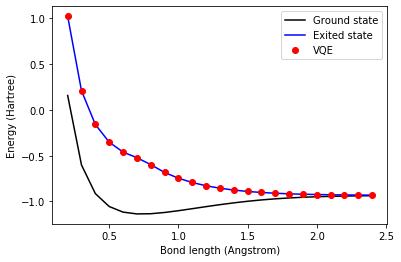

In [7]:
#For recording bond length, VQE, ground state and 1st excited state results
bond_len_list = [];VQE_energy_list=[];gs_list=[];es_list=[]
#Execute the calculation for each bond length
for bond_len in np.arange(0.2,2.5,0.1):
    molecule = get_molecule(bond_len)
    #Determination of the number of bits, depth, initial parameter, and penalty
    n_qubits=molecule.n_qubits
    n_depth=4
    init_params=np.random.rand(n_qubits*n_depth)*0.1
    penalty=10
    #Hamiltonian Definition
    hamiltonian_gs = get_sparse_operator(jordan_wigner(get_fermion_operator(molecule.get_molecular_hamiltonian())))

    #Obtaining the eigenvalues and eigenvectors using classical calculation
    eigen_energy, eigen_vec =np.linalg.eigh((hamiltonian_gs).toarray())
    #Obtaining the wave function of the ground state
    wf_gs=eigen_vec.T[np.argmin(eigen_energy)]

    #Optimization run
    result=minimize(cost,x0=init_params,args=(hamiltonian_gs,n_qubits,n_depth,penalty,wf_gs))

    #Recording bond length, VQE, ground state and 1st excited state results
    bond_len_list.append(bond_len)
    VQE_energy_list.append(result.fun)
    gs_list.append(sorted(eigen_energy)[0])
    es_list.append(sorted(eigen_energy)[1])

#Plotting
import matplotlib.pyplot as plt
plt.plot(bond_len_list,gs_list,label="Ground state",color="black")
plt.plot(bond_len_list,es_list,label="Exited state",color="blue")
plt.plot(bond_len_list,VQE_energy_list, marker="o",label="VQE",color="red",linestyle='None')
plt.xlabel("Bond length (Angstrom)")
plt.ylabel("Energy (Hartree)")
plt.legend()

The results are in good agreement with the exact value of the excited states. While the method used here is the Overlap-based method,  there are various methods to calculate the excited states. Hence, you can try a method that suits your purpose by referencing the papers, for example, [this review](https://arxiv.org/abs/1808.10402).